# Importing packages and set up

In [25]:

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller
import time
import numpy as np
import os
from multiprocess import Pool
import psutil
import statistics
from deap import base, creator
import random
from deap import tools
from array import array
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import scipy

# get number of cpus for multiprocessing
num_cpus = psutil.cpu_count(logical=False)
pool = Pool(num_cpus)

# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

# set up experiment
experiment_name = "Assigment Task 1"
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)
ini = time.time()  # sets time marker
n_hidden_neurons = 10
run_mode = 'train' 
# env.state_to_log() # checks environment state

# number of weights for multilayer with 10 hidden neurons
n_vars = 265


# the fitness function, we use the fitness that the environment returns so it is better to compare to the baseline paper
def simulation(x, enemies, player_controller = player_controller, Environment = Environment):
    #unconventional, but necessary to run code on multiple cores to speed up processing 
    n_hidden_neurons = 10
    experiment_name = 'individual_demo'
    env = Environment(experiment_name=experiment_name,
                  enemies=enemies,
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")
    
    f,p,e,t = env.play(pcont=x)
    return f

# setting deap methods - aim is to maximise the fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# create individuals which contain a strategy vector for self-adaptive mutation - one strategy for each gene
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars # number of weights of the neural network that we will optimize
MIN_VALUE, MAX_VALUE = -1., 1. # Minimum and maximum values of the weights are -1 and 1, respectively
MIN_STRAT, MAX_STRAT = -1., 1. 

# register tools
toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)

#toolbox.register("attribute", np.random.uniform, -1, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", simulation)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
#Make one logbook per enemy and algorithm
logbook_tc_2 = tools.Logbook()
logbook_tc_5 = tools.Logbook()
logbook_tc_7 = tools.Logbook()
logbook_tc_1 = tools.Logbook()

logbook_bc_2 = tools.Logbook()
logbook_bc_5 = tools.Logbook()
logbook_bc_7 = tools.Logbook()
logbook_bc_1 = tools.Logbook()

C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [79]:
#hod to rerun this because it was confused with scipy stats
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

### EAs

In [11]:
# Two point corssover
def twopointcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    #register methods specific for this algorithm 
    toolbox.register("mate", tools.cxESTwoPoint)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)
    
    #evaluationg the individuals, speeded up with multiprocessing
    if __name__ == '__main__':
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit: # to safe the best individual
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # record first random generation
    record = stats.compile(pop)

    #one iteration for each generation 
    for g in range(NGEN):
        # Select parents with tournament selection - we select 200 parents because we want to create 200 children
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        offspring = []
        # create children with two point crossover
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
               
        # mutate offspring
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        #evaluate offspring, again speeded up with multiprocessing
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        #select best 100 survivors from offspring (mu, lambda selection) 
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        #Get statistics and save them to the logbook
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit


In [12]:
#blend crossover
def blendcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    #register methods specific for this algorithm
    toolbox.register("mate", tools.cxESBlend, alpha = 0.5)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)

    #evaluationg the individuals, speeded up with multiprocessing
    if __name__ == '__main__':
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit: # to safe the best individual
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # record first random generation
    record = stats.compile(pop)
    
    #one iteration for each generation
    for g in range(NGEN):
        # Select parents with tournament selection - we select 200 parents because we want to create 200 children 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # create children with two point crossover
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2) #Set alpha to 0.5 for now
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        
        # mutate offspring
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        #evaluate offspring, again speeded up with multiprocessing
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        #select best 100 survivors from offspring (mu, lambda selection) 
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        #Get statistics and save them to the logbook
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit

# Parameter optimization 

### Warning: takes around 8 hours to run

In [3]:
#Parameter optimization using Gridsearch
# for a two-point crossover
pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = twopointcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2
66.53969812413108

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 3
80.84198857579531

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 4
82.79414710221617

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 2
77.2579311603135

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 3
73.6148763154129

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 4
71.96904137437359

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.3
Crossover Probability: 0.7
Tournament Size: 2
68.01754394324428

Offspring Mutation Probability: 0.1
Allele Mutation Probability:

KeyboardInterrupt: 

results first gridsearch
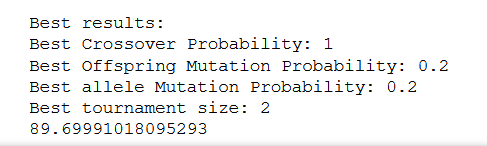

In [6]:
# for blend cx

pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = blendcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2


TypeError: blendcx() missing 2 required positional arguments: 'enemies' and 'logbook'

best params where: (1, 0.2, 0.2, 4)

# Experimental runs

#### Fast code

In [13]:
#Initialize base parameters for experimental run
pop_size = 100
NGEN = 30
runs = 10
gens = []
for i in range(NGEN):
    gens.append(i+1)


# Enemy 2

In [100]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_2 = []
best_scores_tc_2 = []
for i in range(runs):
    best_ind_tc_2, best_score_tc_2 = twopointcx(1, 0.2, 0.2, 2, [2], logbook_tc_2) #tournament size was not set
    best_individuals_tc_2.append(best_ind_tc_2)
    best_scores_tc_2.append(best_score_tc_2)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


13742.362476825714

In [135]:
max(best_scores_tc_2)

93.98272016318508

In [101]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_2 = []
best_scores_bc_2 = []
for i in range(runs):
    best_ind_bc_2, best_score_bc_2 = blendcx(1, 0.2, 0.2, 4, [2], logbook_bc_2) #tournament size was not set
    best_individuals_bc_2.append(best_ind_bc_2)
    best_scores_bc_2.append(best_score_bc_2)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


14079.62653875351

In [136]:
print(max(best_scores_tc_2))
print(max(best_scores_bc_2))
print(max(best_scores_tc_5))
print(max(best_scores_bc_5))
print(max(best_scores_tc_7))
print(max(best_scores_bc_7))

93.98272016318508
94.17611947915373
94.88480267679886
94.85833644349734
92.18341372532801
92.01289246928256


# Boxplot for individual gain against enemy 2

In [16]:
#Run the best individuals 5 times against enemy 2 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[2],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_2 = [] 
for indiv in best_individuals_tc_2:
    fiveruns_tc_2 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_2 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_2.append(individual_gain_tc_2)
    means_tc_2.append(np.mean(fiveruns_tc_2)) # Get the mean individual gain over 5 runs of the best individual
means_tc_2
        
        
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 2; fitness: 92.65092391510478; player life: 82; enemy life: 0; time: 257

RUN: run status: enemy: 2; fitness: 92.33357331188756; player life: 80; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 92.33357331188756; player life: 80; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 74.39876988127112; player life: 0; enemy life: 10.0; time: 736

RUN: run status: enemy: 2; fitness: 74.39876988127112; player life: 0; enemy life: 10.0; time: 736

RUN: run status: enemy: 2; fitness: 92.04317193830046; player life: 76; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 93.37504998251859; player life: 88; enemy life: 0; time: 227

RUN: run status: enemy: 2; fitness: 92.23931836898447; player life: 78; enemy life: 0; time: 260

RUN: run status: enemy: 2; fitness: 93.37504998251859; player life: 88; enemy life: 0; time: 227

RUN: run status: enemy: 2; fitness: 92.23931836898447; player life: 

[44.4, 81.6, 83.2, 76.4, 82.8, 60.8, 66.4, 41.6, 86.0, 84.0]

In [17]:
#Run the best individuals 5 times against enemy 2 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[2],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_2 = []
for indiv in best_individuals_bc_2:
    fiveruns_bc_2 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_2 = p-e
        fiveruns_bc_2.append(individual_gain_bc_2)
    means_bc_2.append(np.mean(fiveruns_bc_2))
means_bc_2


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 2; fitness: 91.83931836898448; player life: 74; enemy life: 0; time: 260

RUN: run status: enemy: 2; fitness: 93.33214184093667; player life: 86; enemy life: 0; time: 194

RUN: run status: enemy: 2; fitness: 92.56627799644576; player life: 80; enemy life: 0; time: 229

RUN: run status: enemy: 2; fitness: 92.56627799644576; player life: 80; enemy life: 0; time: 229

RUN: run status: enemy: 2; fitness: 93.54250462797222; player life: 88; enemy life: 0; time: 192

RUN: run status: enemy: 2; fitness: 87.33616819497439; player life: 28; enemy life: 0; time: 236

RUN: run status: enemy: 2; fitness: 92.73109579777977; player life: 78; enemy life: 0; time: 159

RUN: run status: enemy: 2; fitness: 86.74250462797222; player life: 20; enemy life: 0; time: 192

RUN: run status: enemy: 2; fitness: 92.73109579777977; player life: 78; enemy life: 0; time: 159

RUN: run status: enemy: 2; fitness: 87.33616819497439; player life: 28; 

[81.6, 46.4, -6.4, 60.4, 89.2, 44.0, 84.0, 47.2, 70.0, 83.2]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 2")

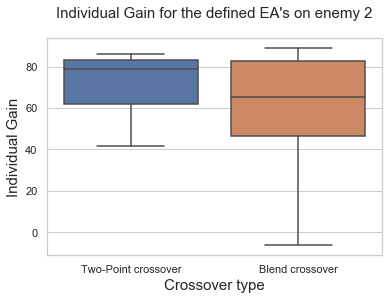

In [123]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
enemy_list_2 = ['AirMan'] * 2 *n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
individual_gains = []
individual_gains.extend(means_tc_2)
individual_gains.extend(means_bc_2)

boxplot_dict_2 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_2}
boxplot_dict_2_pd = pd.DataFrame(boxplot_dict_2)

#sns.set_theme(style="whitegrid")
sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_2_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 2",pad=20, fontsize = 15)

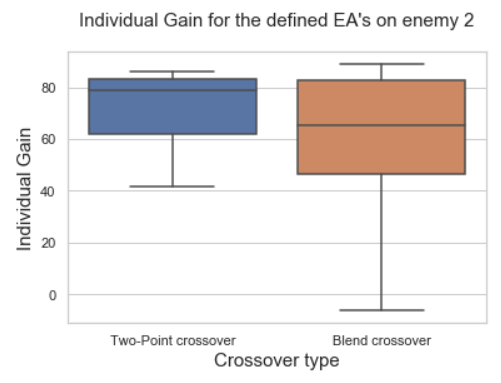

In [110]:
import scipy.stats as statistictest

print(statistictest.ttest_ind(means_tc_2, means_bc_2))

Ttest_indResult(statistic=1.0173665448737559, pvalue=0.32245962858755506)


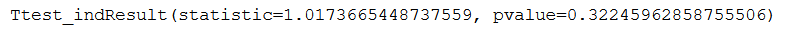

# Lineplots for average and maximum fitness values against enemy 2

In [105]:
averages_tc_2 = []
standard_devs_tc_2 = []
standard_dev_up_tc_2 = []
standard_dev_min_tc_2 = []

maxima_tc_2 = []
maxima_standard_devs_tc_2 = []
maxima_standard_dev_up_tc_2 = []
maxima_standard_dev_min_tc_2 = []

y_tc_2 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_2 = []
    maxima_of_generation_tc_2 = []
    x_tc_2 = y_tc_2
    
    for j in range(runs):
        averages_of_generation_tc_2.append(logbook_tc_2[x_tc_2]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_2.append(logbook_tc_2[x_tc_2]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_2[x_tc_2]['avg'][0])
        x_tc_2 += NGEN
    averages_tc_2.append(sum(averages_of_generation_tc_2)/len(averages_of_generation_tc_2))
    maxima_tc_2.append(sum(maxima_of_generation_tc_2)/len(maxima_of_generation_tc_2))    
    standard_devs_tc_2.append((statistics.stdev(averages_of_generation_tc_2))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_2.append((statistics.stdev(maxima_of_generation_tc_2)))
    y_tc_2+=1
    print(i)
    
    
#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_2)
averages_tc_2_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_2)
standard_devs_tc_2_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_2)
maxima_standard_devs_tc_2_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_2)
maxima_tc_2_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_2.append(averages_tc_2_interp[i]+standard_devs_tc_2_interp[i])
    standard_dev_min_tc_2.append(averages_tc_2_interp[i]-standard_devs_tc_2_interp[i])
    maxima_standard_dev_up_tc_2.append(maxima_tc_2_interp[i]+maxima_standard_devs_tc_2_interp[i])
    maxima_standard_dev_min_tc_2.append(maxima_tc_2_interp[i]-maxima_standard_devs_tc_2_interp[i])
    

33.45643671708157
46.300065468807446
51.87774799466234
43.92220348051508
56.067962487694196
33.07158627448768
25.846522258229935
28.906241531760223
29.468440828906978
30.147575601076696
0
70.2122828833698
79.54910058562797
80.9155433378442
69.59550981106692
84.28311070581839
76.15363085192234
61.452358733953325
66.23702280461366
72.51079546680215
70.56716235848394
1
87.82496115605323
84.75275645324142
87.73169532592128
81.75842408075056
90.63710845819534
86.7893173654042
81.97303804074643
80.52777685248674
88.12827831504613
84.70873515439925
2
89.90428976034262
87.67472613670256
91.60815511530592
86.45178724650889
91.83736119972102
91.4379085785872
89.29704584847974
87.47044137101804
90.62456847079127
86.15060700330599
3
91.90583444653863
91.21525579740617
91.93897918707898
88.17011673224678
91.92558795483019
91.87783733151326
91.14676288605138
88.3778886161293
91.82277962121874
87.35262869203677
4
91.94457567217555
91.83776868170325
91.95597236838844
88.14804716859817
91.9630042608037

[{'gen': 1,
  'evals': 30,
  'avg': array([33.45643672]),
  'std': array([35.13019898]),
  'min': array([-5.75890177]),
  'max': array([91.85873645])},
 {'gen': 2,
  'evals': 30,
  'avg': array([70.21228288]),
  'std': array([18.63161819]),
  'min': array([38.99118681]),
  'max': array([91.93357331])},
 {'gen': 3,
  'evals': 30,
  'avg': array([87.82496116]),
  'std': array([6.40884423]),
  'min': array([67.05124011]),
  'max': array([93.13357331])},
 {'gen': 4,
  'evals': 30,
  'avg': array([89.90428976]),
  'std': array([4.32376689]),
  'min': array([74.7558331]),
  'max': array([92.94041449])},
 {'gen': 5,
  'evals': 30,
  'avg': array([91.90583445]),
  'std': array([0.16360193]),
  'min': array([91.57237889]),
  'max': array([92.766278])},
 {'gen': 6,
  'evals': 30,
  'avg': array([91.94457567]),
  'std': array([0.19101764]),
  'min': array([91.84317194]),
  'max': array([92.966278])},
 {'gen': 7,
  'evals': 30,
  'avg': array([91.92080127]),
  'std': array([0.16658251]),
  'min': 

In [108]:
averages_bc_2 = []
standard_devs_bc_2 = []
standard_dev_up_bc_2 = []
standard_dev_min_bc_2 = []

maxima_bc_2 = []
maxima_standard_devs_bc_2 = []
maxima_standard_dev_up_bc_2 = []
maxima_standard_dev_min_bc_2 = []

y_bc_2 = 0
for i in range(NGEN):
    averages_of_generation_bc_2 = []
    maxima_of_generation_bc_2 = []
    x_bc_2 = y_bc_2
    
    for j in range(runs):
        averages_of_generation_bc_2.append(logbook_bc_2[x_bc_2]['avg'][0])
        maxima_of_generation_bc_2.append(logbook_bc_2[x_bc_2]['max'][0])
        x_bc_2 += NGEN
    averages_bc_2.append(sum(averages_of_generation_bc_2)/len(averages_of_generation_bc_2))
    maxima_bc_2.append(sum(maxima_of_generation_bc_2)/len(maxima_of_generation_bc_2))    
    standard_devs_bc_2.append((statistics.stdev(averages_of_generation_bc_2)))
    maxima_standard_devs_bc_2.append((statistics.stdev(maxima_of_generation_bc_2)))

    y_bc_2+=1

x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_2)
averages_bc_2_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_2)
standard_devs_bc_2_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_2)
maxima_standard_devs_bc_2_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_2)
maxima_bc_2_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_2.append(averages_bc_2_interp[i]+standard_devs_bc_2_interp[i])
    standard_dev_min_bc_2.append(averages_bc_2_interp[i]-standard_devs_bc_2_interp[i])
    maxima_standard_dev_up_bc_2.append(maxima_bc_2_interp[i]+maxima_standard_devs_bc_2_interp[i])
    maxima_standard_dev_min_bc_2.append(maxima_bc_2_interp[i]-maxima_standard_devs_bc_2_interp[i])
    

In [132]:
maxima_of_generation_bc_2

[92.64317193830047,
 93.32772932632852,
 93.54250462797222,
 93.33214184093667,
 92.96627799644577,
 93.33703951986405,
 93.54250462797222,
 92.49466846406764,
 92.91679627126202,
 93.47699002086159]

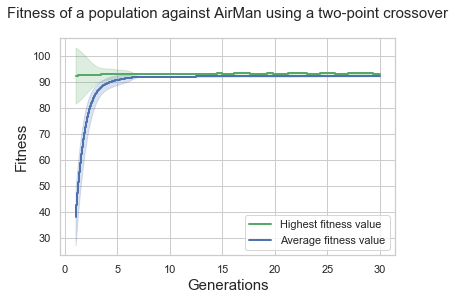

In [137]:
lineplot_2, axes_2 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_2 = 'Mean '

axes_2.step(x_new, maxima_tc_2_interp, label=CB_lab_5, lw=2, color='g')
axes_2.fill_between(x_new, maxima_standard_dev_min_tc_2, maxima_standard_dev_up_tc_2, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_2.step(x_new, averages_tc_2_interp, label=CB_lab_5, lw=2, color='b')
axes_2.fill_between(x_new, standard_dev_min_tc_2, standard_dev_up_tc_2, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against AirMan using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


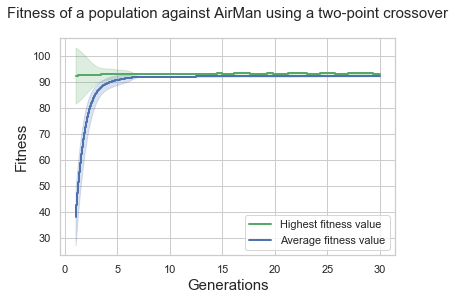

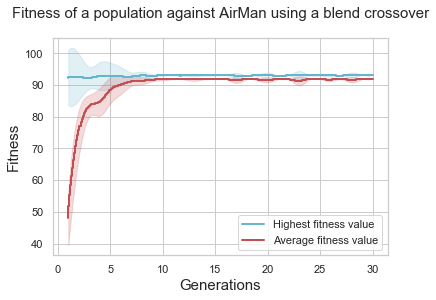

In [138]:
lineplot_2, axes_2 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_2 = 'Mean '

axes_2.step(x_new, maxima_bc_2_interp, label=CB_lab_5, lw=2, color='c')
axes_2.fill_between(x_new, maxima_standard_dev_min_bc_2, maxima_standard_dev_up_bc_2, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_2.step(x_new, averages_bc_2_interp, label=CB_lab_5, lw=2, color='r')
axes_2.fill_between(x_new, standard_dev_min_bc_2, standard_dev_up_bc_2, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against AirMan using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

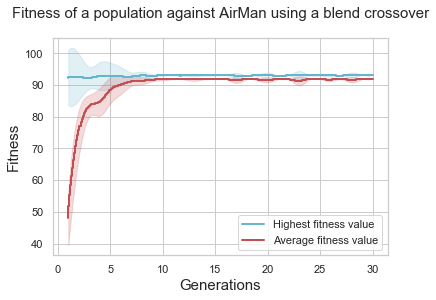

# Enemy 5

In [66]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_5 = []
best_scores_tc_5 = []
for i in range(runs):
    best_ind_tc_5, best_score_tc_5 = twopointcx(1, 0.2, 0.2, 2, [5], logbook_tc_5) #tournament size was not set
    best_individuals_tc_5.append(best_ind_tc_5)
    best_scores_tc_5.append(best_score_tc_5)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


3549.6389515399933

In [80]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_5 = []
best_scores_bc_5 = []
for i in range(runs):
    best_ind_bc_5, best_score_bc_5 = blendcx(1, 0.2, 0.2, 4, [5], logbook_bc_5) #tournament size was not set
    best_individuals_bc_5.append(best_ind_bc_5)
    best_scores_bc_5.append(best_score_bc_5)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


4215.327237606049

# Boxplot for individual gain against Enemy 5

In [69]:
#Run the best individuals 5 times against Enemy 5 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[5],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_5 = [] 
for indiv in best_individuals_tc_5:
    fiveruns_tc_5 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_5 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_5.append(individual_gain_tc_5)
    means_tc_5.append(np.mean(fiveruns_tc_5)) # Get the mean individual gain over 5 runs of the best individual
means_tc_5
        
        
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 5; fitness: 93.15964417492168; player life: 83.80000000000015; enemy life: 0; time: 185

RUN: run status: enemy: 5; fitness: 93.15964417492168; player life: 83.80000000000015; enemy life: 0; time: 185

RUN: run status: enemy: 5; fitness: 89.83367074233114; player life: 59.80000000000033; enemy life: 0; time: 467

RUN: run status: enemy: 5; fitness: 94.28375419465169; player life: 93.40000000000006; enemy life: 0; time: 157

RUN: run status: enemy: 5; fitness: 93.74168263345197; player life: 90.40000000000009; enemy life: 0; time: 200

RUN: run status: enemy: 5; fitness: 93.64670840550224; player life: 88.00000000000011; enemy life: 0; time: 173

RUN: run status: enemy: 5; fitness: 93.26889138314543; player life: 85.00000000000014; enemy life: 0; time: 187

RUN: run status: enemy: 5; fitness: 93.36342770252082; player life: 91.00000000000009; enemy life: 0; time: 310

RUN: run status: enemy: 5; fitness: 92.71703951986

[82.24000000000015,
 87.28000000000013,
 -0.9999999999998266,
 51.40000000000025,
 85.72000000000014,
 85.96000000000012,
 79.12000000000015,
 77.80000000000021,
 84.52000000000014,
 72.28000000000023]

In [81]:
#Run the best individuals 5 times against Enemy 5 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[5],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_5 = []
for indiv in best_individuals_bc_5:
    fiveruns_bc_5 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_5 = p-e
        fiveruns_bc_5.append(individual_gain_bc_5)
    means_bc_5.append(np.mean(fiveruns_bc_5))
means_bc_5


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 5; fitness: 92.33968104797995; player life: 84.40000000000015; enemy life: 0; time: 446

RUN: run status: enemy: 5; fitness: 93.61124010962185; player life: 85.60000000000014; enemy life: 0; time: 141

RUN: run status: enemy: 5; fitness: 92.30873282559585; player life: 83.20000000000016; enemy life: 0; time: 408

RUN: run status: enemy: 5; fitness: 92.33968104797995; player life: 84.40000000000015; enemy life: 0; time: 446

RUN: run status: enemy: 5; fitness: 92.27968104797995; player life: 83.80000000000015; enemy life: 0; time: 446

RUN: run status: enemy: 5; fitness: 87.284107874517; player life: 34.00000000000027; enemy life: 0; time: 453

RUN: run status: enemy: 5; fitness: 91.64814186652396; player life: 70.00000000000028; enemy life: 0; time: 211

RUN: run status: enemy: 5; fitness: 94.52375419465169; player life: 95.80000000000004; enemy life: 0; time: 157

RUN: run status: enemy: 5; fitness: 89.1524835091116

[84.28000000000016,
 47.32000000000023,
 83.68000000000015,
 80.08000000000018,
 75.76000000000018,
 88.12000000000012,
 83.80000000000015,
 67.00000000000023,
 89.4400000000001,
 78.16000000000022]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 5")

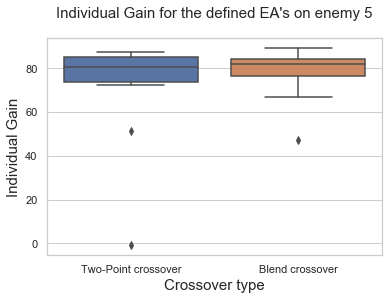

In [122]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_5 = ['MetalMan'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_5)
individual_gains.extend(means_bc_5)

boxplot_dict_5 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_5}
boxplot_dict_5_pd = pd.DataFrame(boxplot_dict_5)

sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_5_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 5",pad=20, fontsize = 15)

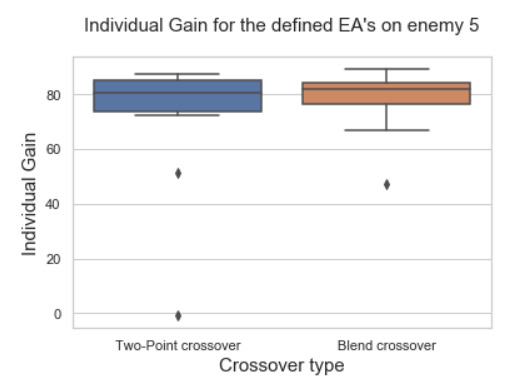

In [86]:
print(statistictest.ttest_ind(means_tc_5, means_bc_5))

Ttest_indResult(statistic=-0.7621253327646823, pvalue=0.4558563785602626)


# Lineplots for average and maximum fitness values against Enemy 5

In [88]:
averages_tc_5 = []
standard_devs_tc_5 = []
standard_dev_up_tc_5 = []
standard_dev_min_tc_5 = []

maxima_tc_5 = []
maxima_standard_devs_tc_5 = []
maxima_standard_dev_up_tc_5 = []
maxima_standard_dev_min_tc_5 = []

y_tc_5 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_5 = []
    maxima_of_generation_tc_5 = []
    x_tc_5 = y_tc_5
    
    for j in range(runs):
        averages_of_generation_tc_5.append(logbook_tc_5[x_tc_5]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_5.append(logbook_tc_5[x_tc_5]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_5[x_tc_5]['avg'][0])
        x_tc_5 += NGEN
    averages_tc_5.append(sum(averages_of_generation_tc_5)/len(averages_of_generation_tc_5))
    maxima_tc_5.append(sum(maxima_of_generation_tc_5)/len(maxima_of_generation_tc_5))    
    standard_devs_tc_5.append((statistics.stdev(averages_of_generation_tc_5))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_5.append((statistics.stdev(maxima_of_generation_tc_5)))
    y_tc_5+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_5)
averages_tc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_5)
standard_devs_tc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_5)
maxima_standard_devs_tc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_5)
maxima_tc_5_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_5.append(averages_tc_5_interp[i]+standard_devs_tc_5_interp[i])
    standard_dev_min_tc_5.append(averages_tc_5_interp[i]-standard_devs_tc_5_interp[i])
    maxima_standard_dev_up_tc_5.append(maxima_tc_5_interp[i]+maxima_standard_devs_tc_5_interp[i])
    maxima_standard_dev_min_tc_5.append(maxima_tc_5_interp[i]-maxima_standard_devs_tc_5_interp[i])
    

39.14390763844171
44.34295487141826
40.675377650246176
29.649613226723396
29.468244967573206
43.0520432939813
40.405638900078245
49.066041633583126
44.76713939811946
35.29010323951944
78.24921551186014
83.39194775611175
72.69185984570049
59.06665907465197
45.81249983665423
83.40054292991817
84.51834669380993
86.85689057304722
82.756436403965
79.11419083245967
90.73538766653922
91.58083851700398
90.30843643515772
89.29866561934126
78.80758103887698
91.76367549331879
91.18518308817688
90.97674198043919
92.21805944669042
90.50859537374541
92.05111017417559
92.42211294149907
92.03447528955425
92.06630789864037
83.32293172026343
92.1810213520739
92.06693323606358
92.13157006273786
92.54132972408338
92.16483252715734
92.391970579884
92.44839229177862
92.96324191257723
92.28972763217286
90.97876715930857
92.68053626728481
92.65082132092749
92.4705471479161
92.65545038301111
92.65443181398264
92.62133555084833
92.85008792814826
92.82621860551913
92.85023541453053
91.81886224822397
93.027520624

In [89]:
averages_bc_5 = []
standard_devs_bc_5 = []
standard_dev_up_bc_5 = []
standard_dev_min_bc_5 = []

maxima_bc_5 = []
maxima_standard_devs_bc_5 = []
maxima_standard_dev_up_bc_5 = []
maxima_standard_dev_min_bc_5 = []

y_bc_5 = 0
for i in range(NGEN):
    averages_of_generation_bc_5 = []
    maxima_of_generation_bc_5 = []
    x_bc_5 = y_bc_5
    
    for j in range(runs):
        averages_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['avg'][0])
        maxima_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['max'][0])
        x_bc_5 += NGEN
    averages_bc_5.append(sum(averages_of_generation_bc_5)/len(averages_of_generation_bc_5))
    maxima_bc_5.append(sum(maxima_of_generation_bc_5)/len(maxima_of_generation_bc_5))    
    standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    maxima_standard_devs_bc_5.append((statistics.stdev(maxima_of_generation_bc_5)))

    y_bc_5+=1

x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_5)
averages_bc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_5)
standard_devs_bc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_5)
maxima_standard_devs_bc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_5)
maxima_bc_5_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_5.append(averages_bc_5_interp[i]+standard_devs_bc_5_interp[i])
    standard_dev_min_bc_5.append(averages_bc_5_interp[i]-standard_devs_bc_5_interp[i])
    maxima_standard_dev_up_bc_5.append(maxima_bc_5_interp[i]+maxima_standard_devs_bc_5_interp[i])
    maxima_standard_dev_min_bc_5.append(maxima_bc_5_interp[i]-maxima_standard_devs_bc_5_interp[i])
    

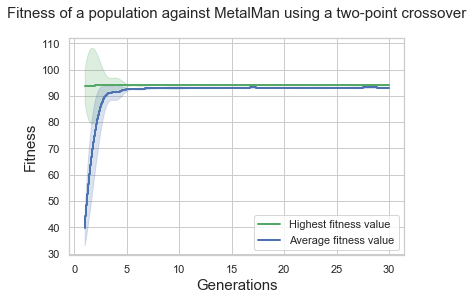

In [139]:
lineplot_5, axes_5 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_5 = 'Mean '

axes_5.step(x_new, maxima_tc_5_interp, label=CB_lab_5, lw=2, color='g')
axes_5.fill_between(x_new, maxima_standard_dev_min_tc_5, maxima_standard_dev_up_tc_5, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_5.step(x_new, averages_tc_5_interp, label=CB_lab_5, lw=2, color='b')
axes_5.fill_between(x_new, standard_dev_min_tc_5, standard_dev_up_tc_5, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against MetalMan using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


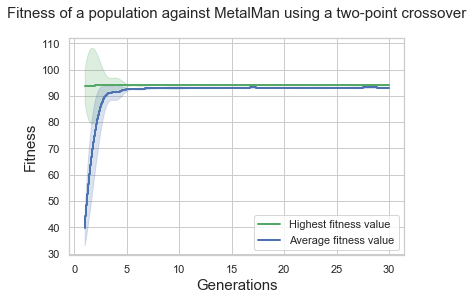

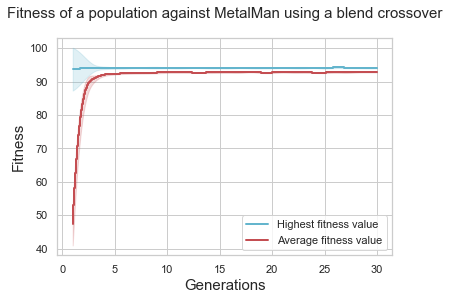

In [140]:
lineplot_5, axes_5 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_5 = 'Mean '

axes_5.step(x_new, maxima_bc_5_interp, label=CB_lab_5, lw=2, color='c')
axes_5.fill_between(x_new, maxima_standard_dev_min_bc_5, maxima_standard_dev_up_bc_5, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_5.step(x_new, averages_bc_5_interp, label=CB_lab_5, lw=2, color='r')
axes_5.fill_between(x_new, standard_dev_min_bc_5, standard_dev_up_bc_5, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against MetalMan using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

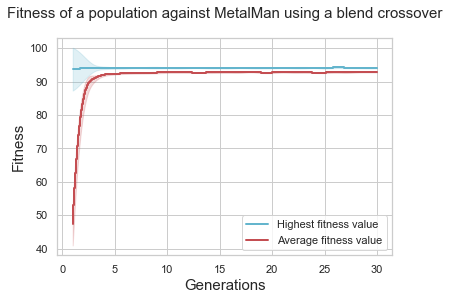

In [ ]:
averages_bc_5 = []
standard_devs_bc_5 = []
standard_dev_up_bc_5 = []
standard_dev_min_bc_5 = []

maxima_bc_5 = []
maxima_standard_devs_bc_5 = []
maxima_standard_dev_up_bc_5 = []
maxima_standard_dev_min_bc_5 = []

y_bc_5 = 0
for i in range(NGEN):
    averages_of_generation_bc_5 = []
    maxima_of_generation_bc_5 = []
    x_bc_5 = y_bc_5
    
    for j in range(runs):
        averages_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['avg'][0])
        maxima_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['max'][0])

        print(logbook_bc_5[x_bc_5]['avg'][0])
        x_bc_5 += NGEN
    averages_bc_5.append(sum(averages_of_generation_bc_5)/len(averages_of_generation_bc_5))
    maxima_bc_5.append(sum(maxima_of_generation_bc_5)/len(maxima_of_generation_bc_5))    
    standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    maxima_standard_devs_bc_5.append((statistics.stdev(maxima_of_generation_bc_5)))

    y_bc_5+=1

x_new = np.linspace(1, NGEN, NGEN*30)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_5)
averages_bc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_5)
standard_devs_bc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_5)
maxima_standard_devs_bc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_5)
maxima_bc_5_interp = a_BSpline(x_new)

for i in range(300):
#     standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    standard_dev_up_bc_5.append(averages_bc_5_interp[i]+standard_devs_bc_5_interp[i])
    standard_dev_min_bc_5.append(averages_bc_5_interp[i]-standard_devs_bc_5_interp[i])
    maxima_standard_dev_up_bc_5.append(maxima_bc_5_interp[i]+maxima_standard_devs_bc_5_interp[i])
    maxima_standard_dev_min_bc_5.append(maxima_bc_5_interp[i]-maxima_standard_devs_bc_5_interp[i])
    

# Enemy 7

In [70]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_7 = []
best_scores_tc_7 = []
for i in range(runs):
    best_ind_tc_7, best_score_tc_7 = twopointcx(1, 0.2, 0.2, 2, [7], logbook_tc_7) #tournament size was not set
    best_individuals_tc_7.append(best_ind_tc_7)
    best_scores_tc_7.append(best_score_tc_7)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


5307.153382062912

In [92]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_7 = []
best_scores_bc_7 = []
for i in range(runs):
    best_ind_bc_7, best_score_bc_7 = blendcx(1, 0.2, 0.2, 4, [7], logbook_bc_7) #tournament size was not set
    best_individuals_bc_7.append(best_ind_bc_7)
    best_scores_bc_7.append(best_score_bc_7)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


4688.127733945847

# Boxplot for individual gain against Enemy 7

In [93]:
#Run the best individuals 5 times against Enemy 7 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[7],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_7 = [] 
for indiv in best_individuals_tc_7:
    fiveruns_tc_7 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_7 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_7.append(individual_gain_tc_7)
    means_tc_7.append(np.mean(fiveruns_tc_7)) # Get the mean individual gain over 5 runs of the best individual
means_tc_7
        
        
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 7; fitness: 89.1838995977956; player life: 46.0000000000003; enemy life: 0; time: 225

RUN: run status: enemy: 7; fitness: 48.24742736117437; player life: 0; enemy life: 40.0; time: 315

RUN: run status: enemy: 7; fitness: 87.22109822612275; player life: 29.80000000000026; enemy life: 0; time: 317

RUN: run status: enemy: 7; fitness: 89.1838995977956; player life: 46.0000000000003; enemy life: 0; time: 225

RUN: run status: enemy: 7; fitness: 89.1838995977956; player life: 46.0000000000003; enemy life: 0; time: 225

RUN: run status: enemy: 7; fitness: 38.98873282559584; player life: 0; enemy life: 50.0; time: 408

RUN: run status: enemy: 7; fitness: 38.98873282559584; player life: 0; enemy life: 50.0; time: 408

RUN: run status: enemy: 7; fitness: 92.18341372532801; player life: 75.40000000000023; enemy life: 0; time: 212

RUN: run status: enemy: 7; fitness: 39.17105438238979; player life: 0; enemy life: 50.0; time: 

[25.560000000000233,
 -18.919999999999952,
 47.400000000000254,
 8.560000000000183,
 -26.0,
 50.76000000000025,
 -10.599999999999937,
 -30.47999999999994,
 34.48000000000016,
 55.24000000000031]

In [94]:
#Run the best individuals 5 times against Enemy 7 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[7],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_7 = []
for indiv in best_individuals_bc_7:
    fiveruns_bc_7 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_7 = p-e
        fiveruns_bc_7.append(individual_gain_bc_7)
    means_bc_7.append(np.mean(fiveruns_bc_7))
means_bc_7


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 7; fitness: 57.30964054567594; player life: 0; enemy life: 30.0; time: 296

RUN: run status: enemy: 7; fitness: 57.30964054567594; player life: 0; enemy life: 30.0; time: 296

RUN: run status: enemy: 7; fitness: 90.26669517527554; player life: 55.60000000000032; enemy life: 0; time: 199

RUN: run status: enemy: 7; fitness: 90.26669517527554; player life: 55.60000000000032; enemy life: 0; time: 199

RUN: run status: enemy: 7; fitness: 86.83703951986408; player life: 25.00000000000025; enemy life: 0; time: 288

RUN: run status: enemy: 7; fitness: 90.45289246928257; player life: 58.00000000000033; enemy life: 0; time: 210

RUN: run status: enemy: 7; fitness: 91.59173296930548; player life: 68.8000000000003; enemy life: 0; time: 198

RUN: run status: enemy: 7; fitness: 90.45289246928257; player life: 58.00000000000033; enemy life: 0; time: 210

RUN: run status: enemy: 7; fitness: 90.45289246928257; player life: 58.000000

[15.24000000000018,
 60.16000000000032,
 -16.0,
 -3.9199999999999333,
 56.3200000000003,
 36.44000000000018,
 64.48000000000027,
 30.640000000000192,
 -1.0399999999998486,
 52.120000000000275]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 7")

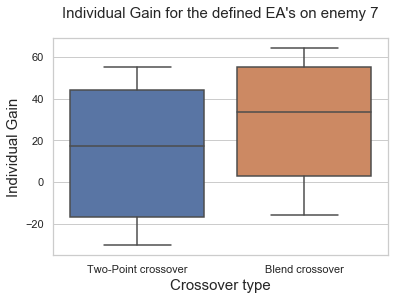

In [121]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_2 = ['BubbleMan'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_7)
individual_gains.extend(means_bc_7)

boxplot_dict_7 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_2}
boxplot_dict_7_pd = pd.DataFrame(boxplot_dict_7)

sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_7_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 7",pad=20, fontsize = 15)

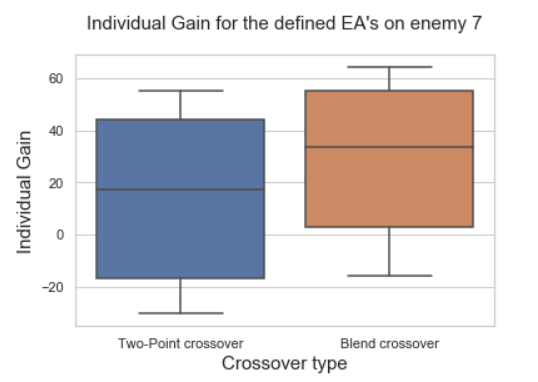

In [111]:
print(statistictest.ttest_ind(means_tc_7, means_bc_7))

Ttest_indResult(statistic=-1.127147223451261, pvalue=0.2744823013574436)


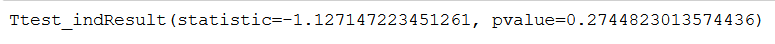

# Lineplots for average and maximum fitness values against Enemy 7

In [96]:
averages_tc_7 = []
standard_devs_tc_7 = []
standard_dev_up_tc_7 = []
standard_dev_min_tc_7 = []

maxima_tc_7 = []
maxima_standard_devs_tc_7 = []
maxima_standard_dev_up_tc_7 = []
maxima_standard_dev_min_tc_7 = []

y_tc_7 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_7 = []
    maxima_of_generation_tc_7 = []
    x_tc_7 = y_tc_7
    
    for j in range(runs):
        averages_of_generation_tc_7.append(logbook_tc_7[x_tc_7]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_7.append(logbook_tc_7[x_tc_7]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_7[x_tc_7]['avg'][0])
        x_tc_7 += NGEN
    averages_tc_7.append(sum(averages_of_generation_tc_7)/len(averages_of_generation_tc_7))
    maxima_tc_7.append(sum(maxima_of_generation_tc_7)/len(maxima_of_generation_tc_7))    
    standard_devs_tc_7.append((statistics.stdev(averages_of_generation_tc_7))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_7.append((statistics.stdev(maxima_of_generation_tc_7)))
    y_tc_7+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_7)
averages_tc_7_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_7)
standard_devs_tc_7_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_7)
maxima_standard_devs_tc_7_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_7)
maxima_tc_7_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_7.append(averages_tc_7_interp[i]+standard_devs_tc_7_interp[i])
    standard_dev_min_tc_7.append(averages_tc_7_interp[i]-standard_devs_tc_7_interp[i])
    maxima_standard_dev_up_tc_7.append(maxima_tc_7_interp[i]+maxima_standard_devs_tc_7_interp[i])
    maxima_standard_dev_min_tc_7.append(maxima_tc_7_interp[i]-maxima_standard_devs_tc_7_interp[i])
    

19.458561857158085
21.44118731116274
30.055722460223652
17.041001088379083
30.729448879654527
26.003823547254925
27.275737236725345
20.149113245688227
22.601522638643942
39.842952617743094
49.79819690169084
45.69092229081769
52.325380039805005
45.573456647863075
50.64843435943066
50.372999555802025
55.05753734505792
48.047613620850214
49.50548908314854
63.4841762383884
59.292353926480104
57.110214512212536
63.69705972674004
57.38879021118002
55.717712970297214
64.97943810115959
66.15619116890947
52.500465311944474
59.61266225947071
62.65220890770993
60.412740118440325
63.42599424291
66.38700198177865
64.385830457777
61.75924242071041
65.60665899632842
66.6496176377764
60.834977040966514
67.08763143851583
64.54438669844542
65.05185908362131
65.72685789637339
64.67389258242824
64.94201931867116
64.84643298422284
66.52255966324728
66.55483105746241
65.42750568523985
67.90791241383278
65.90721480552781
64.66236118983981
66.01196116035811
66.66660511796958
67.37079779778728
66.4349887501221

In [97]:
averages_bc_7 = []
standard_devs_bc_7 = []
standard_dev_up_bc_7 = []
standard_dev_min_bc_7 = []

maxima_bc_7 = []
maxima_standard_devs_bc_7 = []
maxima_standard_dev_up_bc_7 = []
maxima_standard_dev_min_bc_7 = []

y_bc_7 = 0
for i in range(NGEN):
    averages_of_generation_bc_7 = []
    maxima_of_generation_bc_7 = []
    x_bc_7 = y_bc_7
    
    for j in range(runs):
        averages_of_generation_bc_7.append(logbook_bc_7[x_bc_7]['avg'][0])
        maxima_of_generation_bc_7.append(logbook_bc_7[x_bc_7]['max'][0])
        x_bc_7 += NGEN
    averages_bc_7.append(sum(averages_of_generation_bc_7)/len(averages_of_generation_bc_7))
    maxima_bc_7.append(sum(maxima_of_generation_bc_7)/len(maxima_of_generation_bc_7))    
    standard_devs_bc_7.append((statistics.stdev(averages_of_generation_bc_7)))
    maxima_standard_devs_bc_7.append((statistics.stdev(maxima_of_generation_bc_7)))

    y_bc_7+=1

x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_7)
averages_bc_7_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_7)
standard_devs_bc_7_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_7)
maxima_standard_devs_bc_7_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_7)
maxima_bc_7_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_7.append(averages_bc_7_interp[i]+standard_devs_bc_7_interp[i])
    standard_dev_min_bc_7.append(averages_bc_7_interp[i]-standard_devs_bc_7_interp[i])
    maxima_standard_dev_up_bc_7.append(maxima_bc_7_interp[i]+maxima_standard_devs_bc_7_interp[i])
    maxima_standard_dev_min_bc_7.append(maxima_bc_7_interp[i]-maxima_standard_devs_bc_7_interp[i])
    

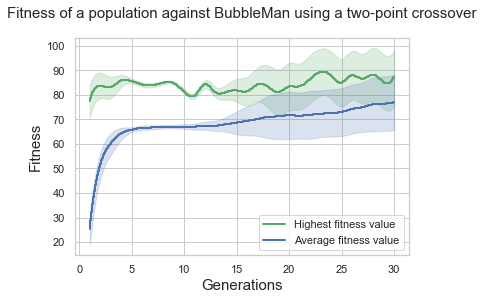

In [141]:
lineplot_7, axes_7 = plt.subplots()
CB_lab_7 = 'Mean PR-curve CatBoost ()' 
lineplot_title_7 = 'Mean '

axes_7.step(x_new, maxima_tc_7_interp, label=CB_lab_7, lw=2, color='g')
axes_7.fill_between(x_new, maxima_standard_dev_min_tc_7, maxima_standard_dev_up_tc_7, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_7.step(x_new, averages_tc_7_interp, label=CB_lab_7, lw=2, color='b')
axes_7.fill_between(x_new, standard_dev_min_tc_7, standard_dev_up_tc_7, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against BubbleMan using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


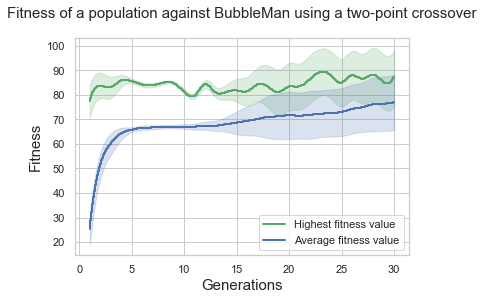

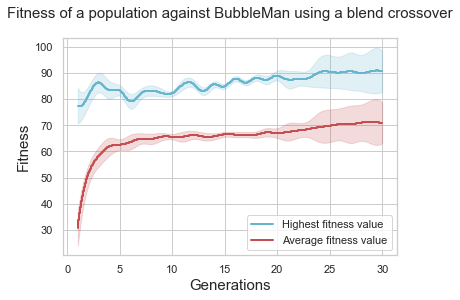

In [142]:
lineplot_7, axes_7 = plt.subplots()
CB_lab_7 = 'Mean PR-curve CatBoost ()' 
lineplot_title_7 = 'Mean '

axes_7.step(x_new, maxima_bc_7_interp, label=CB_lab_7, lw=2, color='c')
axes_7.fill_between(x_new, maxima_standard_dev_min_bc_7, maxima_standard_dev_up_bc_7, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_7.step(x_new, averages_bc_7_interp, label=CB_lab_7, lw=2, color='r')
axes_7.fill_between(x_new, standard_dev_min_bc_7, standard_dev_up_bc_7, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against BubbleMan using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

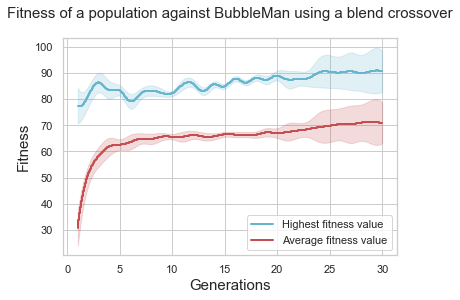

# Enemy 1

In [26]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_1 = []
best_scores_tc_1 = []
for i in range(runs):
    best_ind_tc_1, best_score_tc_1 = twopointcx(1, 0.2, 0.2, 2, [1], logbook_tc_1) #tournament size was not set
    best_individuals_tc_1.append(best_ind_tc_1)
    best_scores_tc_1.append(best_score_tc_1)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


2269.9444451332092

In [33]:
print(logbook_tc_1)

avg          	evals	gen	max          	min          	std          
[3.11228572] 	30   	1  	[57.19486503]	[-4.88280192]	[11.92626587]
[13.24338492]	30   	2  	[57.73214184]	[2.95262782] 	[12.42163195]
[19.25540994]	30   	3  	[66.73214184]	[4.38487948] 	[12.72407445]
[24.57469419]	30   	4  	[57.6018373] 	[12.85250552]	[12.16612022]
[30.47253303]	30   	5  	[57.74772657]	[13.16371809]	[14.8525049] 
[32.50753045]	30   	6  	[75.16226955]	[21.2764149] 	[15.84882946]
[32.67452118]	30   	7  	[91.90284613]	[13.26380155]	[17.13837131]
[31.22090774]	30   	8  	[57.73214184]	[21.2829723] 	[15.292216]  
[27.71416171]	30   	9  	[57.75297593]	[13.16371809]	[14.60040171]
[32.78120191]	30   	10 	[57.75297593]	[21.2829723] 	[16.03571489]
[33.03111145]	30   	11 	[75.75297593]	[21.2829723] 	[16.74982859]
[30.63497224]	30   	12 	[67.16371809]	[13.28150113]	[16.08979177]
[28.88609942]	30   	13 	[66.75297593]	[21.2829723] 	[13.57472006]
[35.08573312]	30   	14 	[75.75297593]	[21.6018373] 	[16.52852208]
[38.380519

In [45]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_1 = []
best_scores_bc_1 = []
for i in range(runs):
    best_ind_bc_1, best_score_bc_1 = blendcx(1, 0.2, 0.2, 4, [1], logbook_bc_1) #tournament size was not set
    best_individuals_bc_1.append(best_ind_bc_1)
    best_scores_bc_1.append(best_score_bc_1)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


2330.3921065330505

# Boxplot for individual gain against Enemy 1

In [43]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[1],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_1 = [] 
for indiv in best_individuals_tc_1:
    fiveruns_tc_1 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_1 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_1.append(individual_gain_tc_1)
    means_tc_1.append(np.mean(fiveruns_tc_1)) # Get the mean individual gain over 5 runs of the best individual
means_tc_1
        
        
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 1; fitness: 94.02326625757942; player life: 90; enemy life: 0; time: 145

RUN: run status: enemy: 1; fitness: 94.02326625757942; player life: 90; enemy life: 0; time: 145

RUN: run status: enemy: 1; fitness: 40.16371809304852; player life: 0; enemy life: 50.0; time: 126

RUN: run status: enemy: 1; fitness: 48.956574883080755; player life: 0; enemy life: 40.0; time: 155

RUN: run status: enemy: 1; fitness: 48.956574883080755; player life: 0; enemy life: 40.0; time: 155

RUN: run status: enemy: 1; fitness: 94.02326625757942; player life: 90; enemy life: 0; time: 145

RUN: run status: enemy: 1; fitness: 94.02326625757942; player life: 90; enemy life: 0; time: 145

RUN: run status: enemy: 1; fitness: 94.02326625757942; player life: 90; enemy life: 0; time: 145

RUN: run status: enemy: 1; fitness: 39.84094470078547; player life: 0; enemy life: 50.0; time: 174

RUN: run status: enemy: 1; fitness: 48.286267194490634; player

[10.0, 36.0, -36.0, -30.0, -18.0, -52.0, -18.0, -56.0, -28.0, 34.0]

In [46]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[1],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_1 = []
for indiv in best_individuals_bc_1:
    fiveruns_bc_1 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_1 = p-e
        fiveruns_bc_1.append(individual_gain_bc_1)
    means_bc_1.append(np.mean(fiveruns_bc_1))
means_bc_1


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 1; fitness: 57.918595635015535; player life: 0; enemy life: 30.0; time: 161

RUN: run status: enemy: 1; fitness: 49.11719807741363; player life: 0; enemy life: 40.0; time: 132

RUN: run status: enemy: 1; fitness: 57.918595635015535; player life: 0; enemy life: 30.0; time: 161

RUN: run status: enemy: 1; fitness: 31.327171165538093; player life: 0; enemy life: 60.0; time: 107

RUN: run status: enemy: 1; fitness: 49.11719807741363; player life: 0; enemy life: 40.0; time: 132

RUN: run status: enemy: 1; fitness: 22.016393378291664; player life: 0; enemy life: 70.0; time: 146

RUN: run status: enemy: 1; fitness: 22.016393378291664; player life: 0; enemy life: 70.0; time: 146

RUN: run status: enemy: 1; fitness: 22.016393378291664; player life: 0; enemy life: 70.0; time: 146

RUN: run status: enemy: 1; fitness: 13.281501128704907; player life: 0; enemy life: 80.0; time: 112

RUN: run status: enemy: 1; fitness: 75.60183729

[-40.0, -60.0, -58.0, -34.0, -44.0, -32.0, -30.0, -20.0, -28.0, -56.0]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 1")

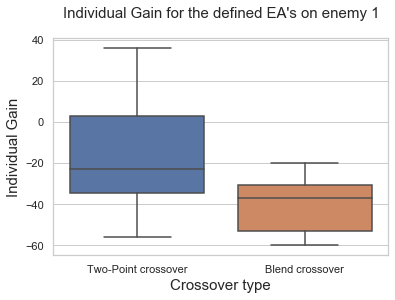

In [48]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_1 = ['1'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_1)
individual_gains.extend(means_bc_1)

boxplot_dict_1 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_1}
boxplot_dict_1_pd = pd.DataFrame(boxplot_dict_1)

sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_1_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 1",pad=20, fontsize = 15)

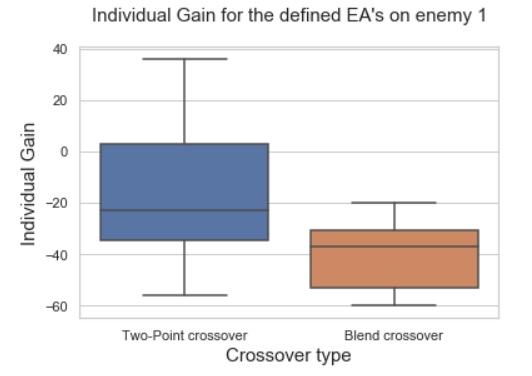

In [76]:
print(stats.ttest_ind(means_tc_1, means_bc_1))

Ttest_indResult(statistic=2.1811231289311688, pvalue=0.04268194707230828)


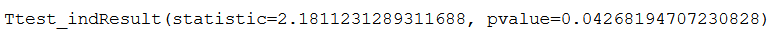

# Lineplots for average and maximum fitness values against Enemy 1

In [41]:
averages_tc_1 = []
standard_devs_tc_1 = []
standard_dev_up_tc_1 = []
standard_dev_min_tc_1 = []

maxima_tc_1 = []
maxima_standard_devs_tc_1 = []
maxima_standard_dev_up_tc_1 = []
maxima_standard_dev_min_tc_1 = []

y_tc_1 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_1 = []
    maxima_of_generation_tc_1 = []
    x_tc_1 = y_tc_1
    
    for j in range(runs):
        averages_of_generation_tc_1.append(logbook_tc_1[x_tc_1]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_1.append(logbook_tc_1[x_tc_1]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_1[x_tc_1]['avg'][0])
        x_tc_1 += NGEN
    averages_tc_1.append(sum(averages_of_generation_tc_1)/len(averages_of_generation_tc_1))
    maxima_tc_1.append(sum(maxima_of_generation_tc_1)/len(maxima_of_generation_tc_1))    
    standard_devs_tc_1.append((statistics.stdev(averages_of_generation_tc_1))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_1.append((statistics.stdev(maxima_of_generation_tc_1)))
    y_tc_1+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_1)
averages_tc_1_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_1)
standard_devs_tc_1_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_1)
maxima_standard_devs_tc_1_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_1)
maxima_tc_1_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_1.append(averages_tc_1_interp[i]+standard_devs_tc_1_interp[i])
    standard_dev_min_tc_1.append(averages_tc_1_interp[i]-standard_devs_tc_1_interp[i])
    maxima_standard_dev_up_tc_1.append(maxima_tc_1_interp[i]+maxima_standard_devs_tc_1_interp[i])
    maxima_standard_dev_min_tc_1.append(maxima_tc_1_interp[i]-maxima_standard_devs_tc_1_interp[i])
    

3.1122857214856077
3.5048199664584696
3.4847510245391216
2.3315724051569995
5.095328714303857
4.271570305931973
0.5866203542273731
3.6894693522546436
3.299976957437464
4.970545999684354
13.243384922346147
9.951843726409718
14.81649909960698
16.077670279864858
18.84682966407745
12.050512267143048
8.624385049365669
13.460505836206526
14.354421609294377
16.09385154331872
19.255409940941355
19.956793988914733
23.381310688689354
23.684294795191125
23.504232737946346
18.64746762636167
15.418094442366543
21.679628640197723
21.63332535422379
23.82280273834647
24.574694191645413
24.030471914187228
25.49361326677873
23.388214229696114
32.33484660702224
25.400810822939984
17.825020699964345
26.55323450524128
29.30014714726557
28.936610063528978
30.472533029134183
22.188066635147443
28.528269221707852
24.794132126065755
31.61901293755217
32.23470287697769
22.991788860248654
29.20232540903091
33.210562821151306
29.575357460742083
32.50753044684254
25.404854062004624
28.118226735620283
27.3501738675

In [71]:
averages_bc_1 = []
standard_devs_bc_1 = []
standard_dev_up_bc_1 = []
standard_dev_min_bc_1 = []

maxima_bc_1 = []
maxima_standard_devs_bc_1 = []
maxima_standard_dev_up_bc_1 = []
maxima_standard_dev_min_bc_1 = []

y_bc_1 = 0
for i in range(NGEN):
    averages_of_generation_bc_1 = []
    maxima_of_generation_bc_1 = []
    x_bc_1 = y_bc_1
    
    for j in range(runs):
        averages_of_generation_bc_1.append(logbook_bc_1[x_bc_1]['avg'][0])
        maxima_of_generation_bc_1.append(logbook_bc_1[x_bc_1]['max'][0])
        x_bc_1 += NGEN
    averages_bc_1.append(sum(averages_of_generation_bc_1)/len(averages_of_generation_bc_1))
    maxima_bc_1.append(sum(maxima_of_generation_bc_1)/len(maxima_of_generation_bc_1))    
    standard_devs_bc_1.append((statistics.stdev(averages_of_generation_bc_1)))
    maxima_standard_devs_bc_1.append((statistics.stdev(maxima_of_generation_bc_1)))

    y_bc_1+=1

x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_1)
averages_bc_1_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_1)
standard_devs_bc_1_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_1)
maxima_standard_devs_bc_1_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_1)
maxima_bc_1_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_1.append(averages_bc_1_interp[i]+standard_devs_bc_1_interp[i])
    standard_dev_min_bc_1.append(averages_bc_1_interp[i]-standard_devs_bc_1_interp[i])
    maxima_standard_dev_up_bc_1.append(maxima_bc_1_interp[i]+maxima_standard_devs_bc_1_interp[i])
    maxima_standard_dev_min_bc_1.append(maxima_bc_1_interp[i]-maxima_standard_devs_bc_1_interp[i])
    

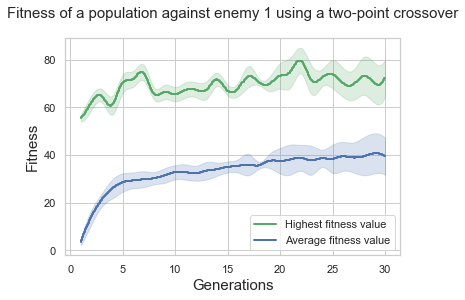

In [42]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_tc_1_interp, label=CB_lab_1, lw=2, color='g')
axes_1.fill_between(x_new, maxima_standard_dev_min_tc_1, maxima_standard_dev_up_tc_1, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_tc_1_interp, label=CB_lab_1, lw=2, color='b')
axes_1.fill_between(x_new, standard_dev_min_tc_1, standard_dev_up_tc_1, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 1 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


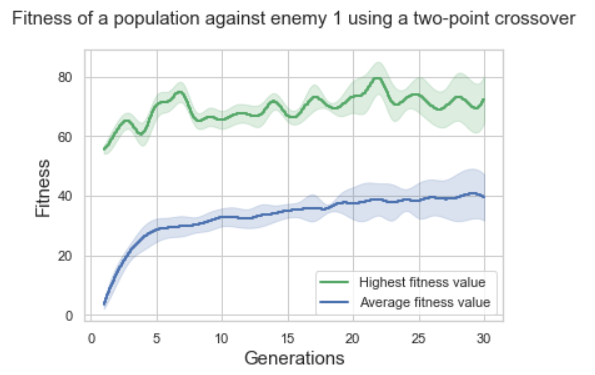

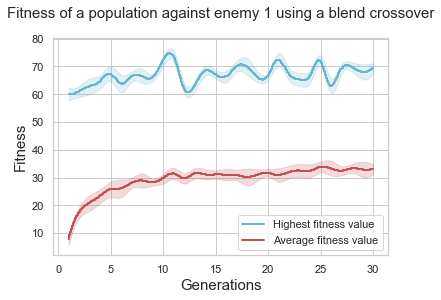

In [72]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_bc_1_interp, label=CB_lab_1, lw=2, color='c')
axes_1.fill_between(x_new, maxima_standard_dev_min_bc_1, maxima_standard_dev_up_bc_1, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_bc_1_interp, label=CB_lab_1, lw=2, color='r')
axes_1.fill_between(x_new, standard_dev_min_bc_1, standard_dev_up_bc_1, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 1 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

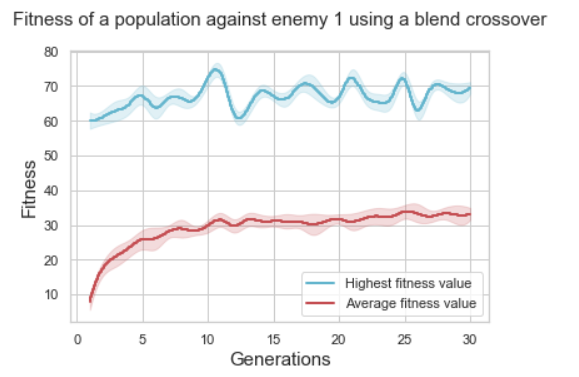

In [124]:
total_boxplot_pd = pd.concat([boxplot_dict_2_pd, boxplot_dict_5_pd, boxplot_dict_7_pd], axis=0)

In [125]:
total_boxplot_pd

,Individual Gain,Crossover type,Enemy
0,44.40,Two-Point crossover,AirMan
1,81.60,Two-Point crossover,AirMan
2,83.20,Two-Point crossover,AirMan
3,76.40,Two-Point crossover,AirMan
4,82.80,Two-Point crossover,AirMan
5,60.80,Two-Point crossover,AirMan
6,66.40,Two-Point crossover,AirMan
7,41.60,Two-Point crossover,AirMan
8,86.00,Two-Point crossover,AirMan
9,84.00,Two-Point crossover,AirMan


In [ ]:
total_boxplot_pd["Enemy"]

Text(0.5, 1.0, "Individual Gain for the defined EA's per enemy")

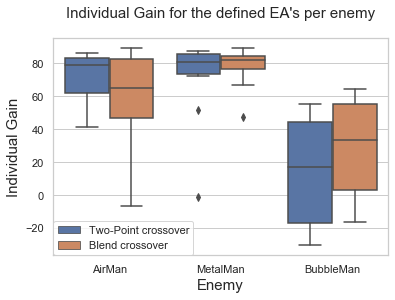

In [126]:
ax = sns.boxplot(x="Enemy", y="Individual Gain", hue="Crossover type",
                 data=total_boxplot_pd)
plt.legend(loc=3, borderaxespad=0.)
ax.set_xlabel("Enemy", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's per enemy", pad=20, fontsize = 15)


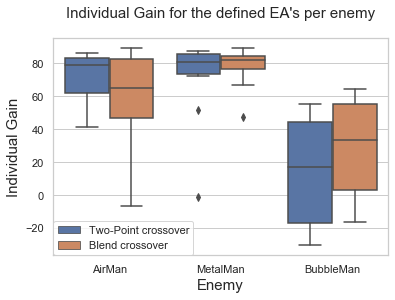

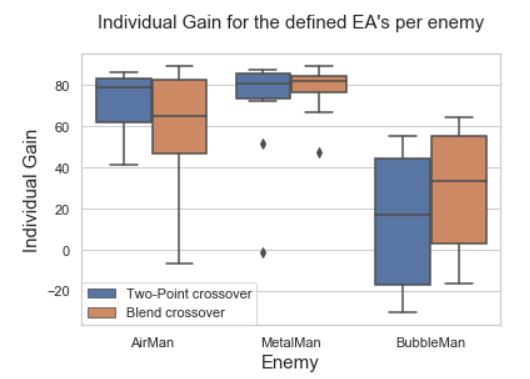

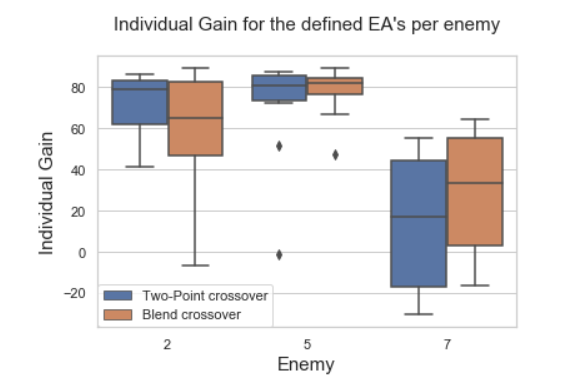enemy 6

# Enemy 6

In [52]:
logbook_tc_6 = tools.Logbook()
logbook_bc_6 = tools.Logbook()

In [53]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_6 = []
best_scores_tc_6 = []
for i in range(runs):
    best_ind_tc_6, best_score_tc_6 = twopointcx(1, 0.2, 0.2, 2, [6], logbook_tc_6) #tournament size was not set
    best_individuals_tc_6.append(best_ind_tc_6)
    best_scores_tc_6.append(best_score_tc_6)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


2051.5888097286224

In [54]:
print(logbook_tc_6)

avg          	evals	gen	max          	min          	std          
[1.3040751]  	30   	1  	[39.91859564]	[-4.81218436]	[9.32817097] 
[4.54392664] 	30   	2  	[87.88506424]	[-4.58496748]	[12.50084292]
[11.95513853]	30   	3  	[75.26990022]	[-4.21950771]	[15.37275286]
[13.25266405]	30   	4  	[85.35282823]	[3.33357331] 	[14.92788599]
[17.26045574]	30   	5  	[66.67699002]	[3.96956208] 	[15.57615496]
[22.02822193]	30   	6  	[86.97282823]	[3.66728121] 	[20.79077379]
[30.2531678] 	30   	7  	[87.63289247]	[4.22931538] 	[21.50264185]
[36.75055706]	30   	8  	[75.76355804]	[12.59732262]	[17.3745884] 
[44.94635323]	30   	9  	[75.76355804]	[21.83521403]	[14.2442451] 
[52.3771405] 	30   	10 	[89.77740497]	[30.92482618]	[13.62581422]
[54.76777419]	30   	11 	[87.20669518]	[31.04417294]	[14.14547565]
[56.98767751]	30   	12 	[86.62506424]	[39.75297593]	[12.86358581]
[60.65822274]	30   	13 	[89.26506424]	[48.35102576]	[10.99684063]
[59.01052508]	30   	14 	[88.96506424]	[39.89405453]	[13.65883855]
[59.535774

In [55]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_6 = []
best_scores_bc_6 = []
for i in range(runs):
    best_ind_bc_6, best_score_bc_6 = blendcx(1, 0.2, 0.2, 4, [6], logbook_bc_6) #tournament size was not set
    best_individuals_bc_6.append(best_ind_bc_6)
    best_scores_bc_6.append(best_score_bc_6)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


2029.777429819107

# Boxplot for individual gain against Enemy 1

In [56]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[6],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_6 = [] 
for indiv in best_individuals_tc_6:
    fiveruns_tc_6 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_6 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_6.append(individual_gain_tc_6)
    means_tc_6.append(np.mean(fiveruns_tc_6)) # Get the mean individual gain over 5 runs of the best individual
means_tc_6     
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 6; fitness: 30.696695091940924; player life: 0; enemy life: 60.0; time: 201

RUN: run status: enemy: 6; fitness: 48.823850267426174; player life: 0; enemy life: 40.0; time: 177

RUN: run status: enemy: 6; fitness: 48.823850267426174; player life: 0; enemy life: 40.0; time: 177

RUN: run status: enemy: 6; fitness: 90.43109579777979; player life: 55.00000000000032; enemy life: 0; time: 159

RUN: run status: enemy: 6; fitness: 48.823850267426174; player life: 0; enemy life: 40.0; time: 177

RUN: run status: enemy: 6; fitness: 57.42027017401378; player life: 0; enemy life: 30.0; time: 265

RUN: run status: enemy: 6; fitness: 57.42027017401378; player life: 0; enemy life: 30.0; time: 265

RUN: run status: enemy: 6; fitness: 89.06355803717008; player life: 43.00000000000029; enemy life: 0; time: 188

RUN: run status: enemy: 6; fitness: 48.46266573298146; player life: 0; enemy life: 40.0; time: 254

RUN: run status: enemy: 

[-24.999999999999936,
 -15.399999999999944,
 -5.039999999999884,
 -16.799999999999862,
 -18.0,
 -50.0,
 -30.07999999999989,
 -4.03999999999982,
 35.840000000000266,
 0.12000000000015518]

In [57]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[6],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_6 = []
for indiv in best_individuals_bc_6:
    fiveruns_bc_6 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_6 = p-e
        fiveruns_bc_6.append(individual_gain_bc_6)
    means_bc_6.append(np.mean(fiveruns_bc_6))
means_bc_6


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 6; fitness: 88.24506424239104; player life: 34.60000000000027; enemy life: 0; time: 184

RUN: run status: enemy: 6; fitness: 39.286267194490634; player life: 0; enemy life: 50.0; time: 303

RUN: run status: enemy: 6; fitness: 39.286267194490634; player life: 0; enemy life: 50.0; time: 303

RUN: run status: enemy: 6; fitness: 85.95616819497441; player life: 14.200000000000228; enemy life: 0; time: 236

RUN: run status: enemy: 6; fitness: 85.95616819497441; player life: 14.200000000000228; enemy life: 0; time: 236

RUN: run status: enemy: 6; fitness: 88.2893574474123; player life: 42.40000000000029; enemy life: 0; time: 384

RUN: run status: enemy: 6; fitness: 90.94878821817866; player life: 65.80000000000032; enemy life: 0; time: 279

RUN: run status: enemy: 6; fitness: 21.17399989261955; player life: 0; enemy life: 70.0; time: 339

RUN: run status: enemy: 6; fitness: 88.2893574474123; player life: 42.40000000000029; 

[-7.399999999999852,
 24.720000000000237,
 26.320000000000256,
 -27.19999999999991,
 32.200000000000266,
 1.280000000000183,
 -59.75999999999995,
 -42.87999999999995,
 -38.95999999999996,
 -62.0]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 6")

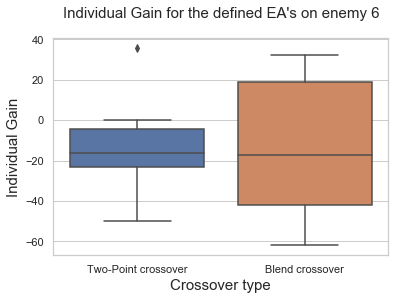

In [62]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_1 = ['1'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_6)
individual_gains.extend(means_bc_6)

boxplot_dict_1 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_1}
boxplot_dict_1_pd = pd.DataFrame(boxplot_dict_1)

sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_1_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 6",pad=20, fontsize = 15)

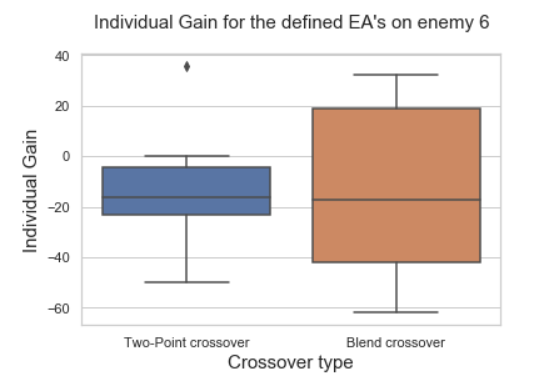

In [77]:
print(stats.ttest_ind(means_tc_6, means_bc_6))

Ttest_indResult(statistic=0.1890233414766459, pvalue=0.8521894952353907)


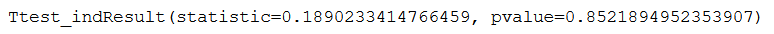

# Lineplots for average and maximum fitness values against Enemy 1

In [59]:
averages_tc_6 = []
standard_devs_tc_6 = []
standard_dev_up_tc_6 = []
standard_dev_min_tc_6 = []

maxima_tc_6 = []
maxima_standard_devs_tc_6 = []
maxima_standard_dev_up_tc_6 = []
maxima_standard_dev_min_tc_6 = []

y_tc_6 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_6 = []
    maxima_of_generation_tc_6 = []
    x_tc_6 = y_tc_6
    
    for j in range(runs):
        averages_of_generation_tc_6.append(logbook_tc_6[x_tc_6]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_6.append(logbook_tc_6[x_tc_6]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_6[x_tc_6]['avg'][0])
        x_tc_6 += NGEN
    averages_tc_6.append(sum(averages_of_generation_tc_6)/len(averages_of_generation_tc_6))
    maxima_tc_6.append(sum(maxima_of_generation_tc_6)/len(maxima_of_generation_tc_6))    
    standard_devs_tc_6.append((statistics.stdev(averages_of_generation_tc_6))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_6.append((statistics.stdev(maxima_of_generation_tc_6)))
    y_tc_6+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_6)
averages_tc_6_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_6)
standard_devs_tc_6_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_6)
maxima_standard_devs_tc_6_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_6)
maxima_tc_6_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_6.append(averages_tc_6_interp[i]+standard_devs_tc_6_interp[i])
    standard_dev_min_tc_6.append(averages_tc_6_interp[i]-standard_devs_tc_6_interp[i])
    maxima_standard_dev_up_tc_6.append(maxima_tc_6_interp[i]+maxima_standard_devs_tc_6_interp[i])
    maxima_standard_dev_min_tc_6.append(maxima_tc_6_interp[i]-maxima_standard_devs_tc_6_interp[i])
    

1.3040750953121343
2.834559461612821
1.9633580995042519
1.3718869611604712
1.116482833035628
3.660486883436473
1.4495949481061177
0.016718475262919485
0.04765207484393807
-0.10242022822222316
4.543926639071833
7.626794353181269
6.821396402674271
4.502842357610933
5.37769131953036
10.566121205929385
4.3764864714315665
1.3478820916789231
5.4836349474672765
4.621071005081187
11.955138526534974
10.485277971278897
13.741552645981802
8.884681337279552
11.66737302714131
8.535295882057898
11.332784815356582
5.815971386737439
6.556395135301054
11.164974936637535
13.252664052071564
12.460812285452137
15.822165628042715
13.128818966843989
15.701487177857032
10.924686238821145
16.646285396647613
10.981911852655507
9.551694090643863
13.916296730974432
17.260455735819892
18.431329844833964
18.678150092801346
14.35208524584597
17.359566987730748
10.7133016736279
19.978504307602304
16.255118470543003
14.624889558748318
16.780837658726313
22.02822193420809
17.032882313300732
17.904013816850853
15.04666

In [73]:
averages_bc_6 = []
standard_devs_bc_6 = []
standard_dev_up_bc_6 = []
standard_dev_min_bc_6 = []

maxima_bc_6 = []
maxima_standard_devs_bc_6 = []
maxima_standard_dev_up_bc_6 = []
maxima_standard_dev_min_bc_6 = []

y_bc_6 = 0
for i in range(NGEN):
    averages_of_generation_bc_6 = []
    maxima_of_generation_bc_6 = []
    x_bc_6 = y_bc_6
    
    for j in range(runs):
        averages_of_generation_bc_6.append(logbook_bc_6[x_bc_6]['avg'][0])
        maxima_of_generation_bc_6.append(logbook_bc_6[x_bc_6]['max'][0])
        x_bc_6 += NGEN
    averages_bc_6.append(sum(averages_of_generation_bc_6)/len(averages_of_generation_bc_6))
    maxima_bc_6.append(sum(maxima_of_generation_bc_6)/len(maxima_of_generation_bc_6))    
    standard_devs_bc_6.append((statistics.stdev(averages_of_generation_bc_6)))
    maxima_standard_devs_bc_6.append((statistics.stdev(maxima_of_generation_bc_6)))

    y_bc_6+=1

x_new = np.linspace(1, NGEN, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_6)
averages_bc_6_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_6)
standard_devs_bc_6_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_6)
maxima_standard_devs_bc_6_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_6)
maxima_bc_6_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_6.append(averages_bc_6_interp[i]+standard_devs_bc_6_interp[i])
    standard_dev_min_bc_6.append(averages_bc_6_interp[i]-standard_devs_bc_6_interp[i])
    maxima_standard_dev_up_bc_6.append(maxima_bc_6_interp[i]+maxima_standard_devs_bc_6_interp[i])
    maxima_standard_dev_min_bc_6.append(maxima_bc_6_interp[i]-maxima_standard_devs_bc_6_interp[i])

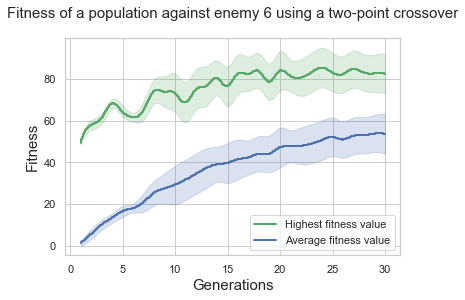

In [64]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_tc_6_interp, label=CB_lab_1, lw=2, color='g')
axes_1.fill_between(x_new, maxima_standard_dev_min_tc_6, maxima_standard_dev_up_tc_6, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_tc_6_interp, label=CB_lab_1, lw=2, color='b')
axes_1.fill_between(x_new, standard_dev_min_tc_6, standard_dev_up_tc_6, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 6 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

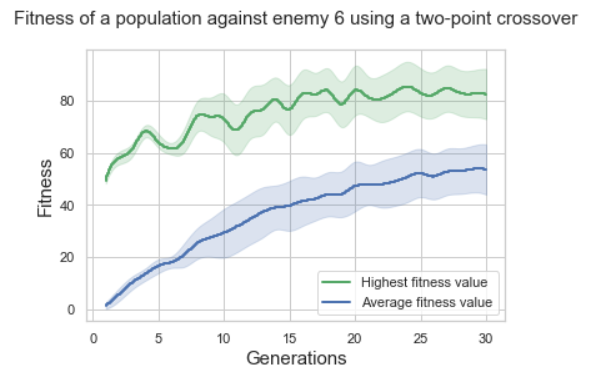

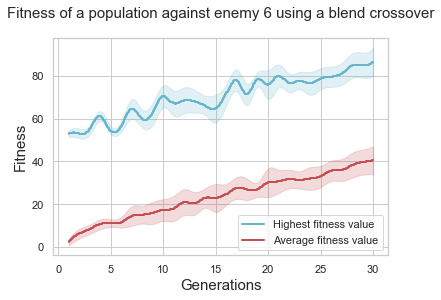

In [74]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_bc_6_interp, label=CB_lab_1, lw=2, color='c')
axes_1.fill_between(x_new, maxima_standard_dev_min_bc_6, maxima_standard_dev_up_bc_6, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_bc_6_interp, label=CB_lab_1, lw=2, color='r')
axes_1.fill_between(x_new, standard_dev_min_bc_6, standard_dev_up_bc_6, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 6 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

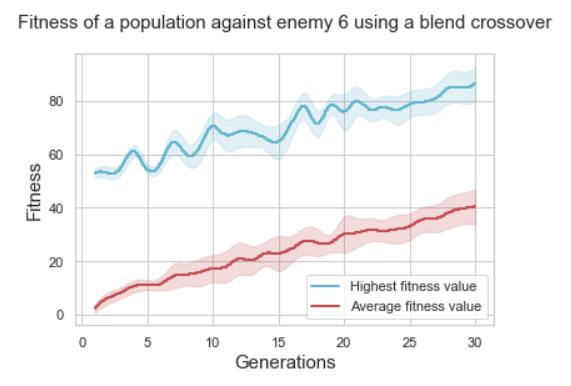

In [143]:
import pickle
pickle.dump( logbook_tc_2, open( "logbook_tc_2.p", "wb" ) )